#Maximum Mean Discrepancy Variational Autoencoder

Details and motivation are described in this [paper](https://arxiv.org/abs/1706.02262) or [tutorial](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/). 
This implementation is evaluated on MNIST, we can generate reasonable quality samples by using Maximum Mean Discrepancy rather than a direct KL Divergence that is commonly present in Variational Autoencoders.

**Author:** Jhosimar George Arias Figueroa

## Install Pytorch

In [1]:
!pip install torch

## Import Libraries

In [0]:
import random
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

## Environment and Seed

In [0]:
CUDA = 1          # if we run the code on GPU
SEED = 1          # random seed

In [0]:
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if CUDA:
  torch.cuda.manual_seed(SEED)

## MNIST Dataset

The MNIST dataset consists of 70000 handwritten digits of 28×28 pixel size and 10 classes, of which 60000 images are considered for training and 10000 images for testing. This dataset can be obtained directly from the [dataset package](https://pytorch.org/docs/stable/torchvision/datasets.html/).

In [5]:
# Download or load downloaded MNIST dataset
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

0it [00:00, ?it/s]

9920512it [00:01, 8156263.50it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 123238.44it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2161211.89it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50261.09it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Let's visualize what the training data looks like:

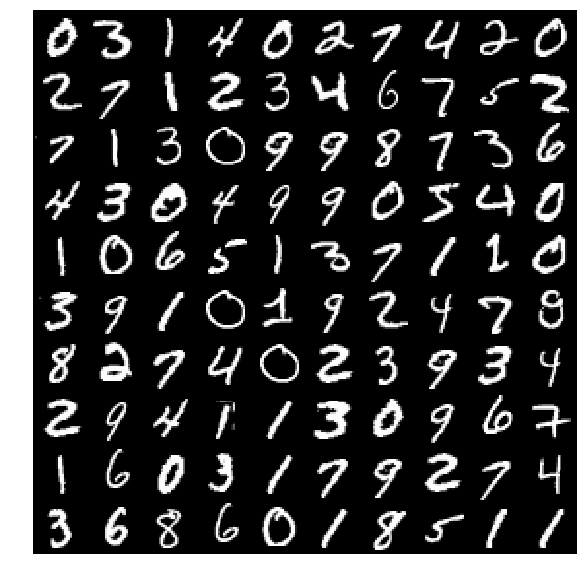

In [6]:
def display_dataset(X, H, W, n=10):
  grid = np.zeros((H * n, W * n))
  for i in range(n):
    for j in range(n):
      index = np.random.randint(X.shape[0])
      sample = X[index].reshape(H, W)
      grid[i*H:i*H+H,j*W:j*W+W] = sample
  
  plt.figure(figsize=(n, n))
  plt.imshow(grid, cmap=plt.get_cmap('gray'))
  plt.grid(False)
  plt.axis("off")
  plt.show()
  
visualize_data = train_dataset.data[0:100].numpy()
img_rows, img_cols = visualize_data.shape[1], visualize_data.shape[2]
display_dataset(visualize_data, img_rows, img_cols)

## Auxiliary Layers

In [0]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
  def __init__(self, outer_shape):
    super(Reshape, self).__init__()
    self.outer_shape = outer_shape
  def forward(self, x):
    return x.view(x.size(0), *self.outer_shape)

## Autoencoder

In [0]:
class AE(nn.Module):
  
  def __init__(self, z_dim):
    super(AE, self).__init__()
    self.encoder = torch.nn.ModuleList([
        torch.nn.Conv2d(1, 64, 4, 2, padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2, padding=1),
        torch.nn.LeakyReLU(),
        Flatten(),
        torch.nn.Linear(6272, 1024),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(1024, z_dim)
    ])
    
    
    self.decoder = torch.nn.ModuleList([
        torch.nn.Linear(z_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
        torch.nn.Sigmoid()
    ])
    
    def init_weights(m):
      if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.xavier_uniform_(m.weight)
    
    self.encoder.apply(init_weights)
    self.decoder.apply(init_weights)
  
  def encode(self, x):
    for layer in self.encoder:
      x = layer(x)
    return x
  
  def decode(self, z):
    for layer in self.decoder:
      z = layer(z)
    return z
  
  def forward(self, x):
    z = self.encode(x)
    out = self.decode(z)
    return z, out

## Maximum Mean Discrepancy (MMD)

In [0]:
def compute_kernel(x, y):
  x_size = x.size(0)
  y_size = y.size(0)
  dim = x.size(1)
  x = x.unsqueeze(1) # (x_size, 1, dim)
  y = y.unsqueeze(0) # (1, y_size, dim)
  tiled_x = x.expand(x_size, y_size, dim)
  tiled_y = y.expand(x_size, y_size, dim)
  kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
  return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
  x_kernel = compute_kernel(x, x)
  y_kernel = compute_kernel(y, y)
  xy_kernel = compute_kernel(x, y)
  mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
  return mmd

### Loss Function

In [0]:
LAMBDA = 1
def loss_ae(x, x_recon, z, true_samples):
  REC = F.binary_cross_entropy(x_recon, x, reduction='none')
  REC = REC.sum(dim=(1,2,3)).mean()
  MMD = compute_mmd(true_samples, z)
  return REC + LAMBDA * MMD, REC, MMD

## Train and Evaluation Functions

Define a function to train the model

In [0]:
def train(model, optimizer, loader):
  model.train()
  total_loss = 0.
  recon_loss = 0.
  mmd_loss = 0.
  num_batches = 0.
  
  for batch_index, (data, labels) in enumerate(loader):
    if CUDA == 1:
      data = data.cuda()
    optimizer.zero_grad()
    # forward call
    z, data_recon = model(data)
    # generate gaussian samples
    true_samples = torch.randn_like(z)
    if CUDA == 1:
      true_samples = true_samples.cuda()
    # calculate loss  
    total, rec, mmd = loss_ae(data, data_recon, z, true_samples)  
    total_loss += total
    recon_loss += rec
    mmd_loss += mmd
    # perform backpropagation
    total.backward()
    optimizer.step()
    
    num_batches += 1.
  
  total_loss /= num_batches
  recon_loss /= num_batches
  mmd_loss /= num_batches
  
  return total_loss, recon_loss, mmd_loss

Define a function to evaluate the model

In [0]:
def test(model, loader):
  model.eval()
  total_loss = 0.
  recon_loss = 0.
  mmd_loss = 0.
  num_batches = 0.

  for batch_index, (data, labels) in enumerate(loader):
    if CUDA == 1:
      data = data.cuda()
    # forward call
    z, data_recon = model(data)
    # generate gaussian samples
    true_samples = torch.randn_like(z)
    if CUDA == 1:
      true_samples = true_samples.cuda()
    # calculate loss  
    total, rec, mmd = loss_ae(data, data_recon, z, true_samples)  
    total_loss += total
    recon_loss += rec
    mmd_loss += mmd
    
    num_batches += 1.
  
  total_loss /= num_batches
  recon_loss /= num_batches
  mmd_loss /= num_batches
  
  return total_loss, recon_loss, mmd_loss

## Data Partition

Obtain random indices for training and validation

In [0]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(train_dataset), 0.8)

Partition dataset given indices and batch size

In [0]:
BATCH_SIZE = 200
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(val_indices))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train Model

Define the model, optimizer and hyperparameters before training and testing

In [0]:
LATENT_DIM = 10
LAMBDA = 10
model = AE(LATENT_DIM)
if CUDA:
  model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Train and validate the model

In [16]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
  train_loss, train_rec, train_mmd = train(model, optimizer, train_loader)
  val_loss, val_rec, val_mmd = test(model, val_loader)
  print('Epoch (%d/%d) - Train_Loss: %.3lf, Val_Loss: %.3lf' % (epoch, EPOCHS, train_loss, val_loss))
  print('Train - REC: %.5lf, MMD: %.5lf | Val - REC: %.5lf, MMD: %.5lf' % (train_rec, train_mmd, val_rec, val_mmd))

Epoch (1/50) - Train_Loss: 146.144, Val_Loss: 91.401
Train - REC: 144.04707, MMD: 0.20969 | Val - REC: 90.79342, MMD: 0.06075
Epoch (2/50) - Train_Loss: 86.293, Val_Loss: 82.248
Train - REC: 85.91231, MMD: 0.03803 | Val - REC: 82.00136, MMD: 0.02466
Epoch (3/50) - Train_Loss: 80.611, Val_Loss: 78.932
Train - REC: 80.38832, MMD: 0.02229 | Val - REC: 78.72786, MMD: 0.02038
Epoch (4/50) - Train_Loss: 77.819, Val_Loss: 77.063
Train - REC: 77.65414, MMD: 0.01646 | Val - REC: 76.94679, MMD: 0.01158
Epoch (5/50) - Train_Loss: 76.017, Val_Loss: 75.725
Train - REC: 75.88371, MMD: 0.01331 | Val - REC: 75.60727, MMD: 0.01176
Epoch (6/50) - Train_Loss: 74.723, Val_Loss: 74.645
Train - REC: 74.61017, MMD: 0.01131 | Val - REC: 74.54445, MMD: 0.01002
Epoch (7/50) - Train_Loss: 73.665, Val_Loss: 73.809
Train - REC: 73.56319, MMD: 0.01014 | Val - REC: 73.72299, MMD: 0.00862
Epoch (8/50) - Train_Loss: 72.788, Val_Loss: 73.386
Train - REC: 72.69833, MMD: 0.00893 | Val - REC: 73.30828, MMD: 0.00773
Epoch 

## Image Reconstruction

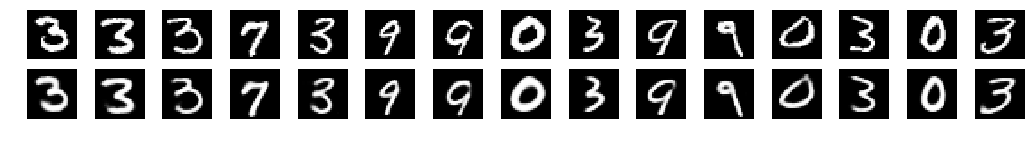

In [17]:
def reconstruction(model, test_dataset, SAMPLE_SIZE=15):
  model.eval()
  indices = np.random.randint(0, len(test_dataset), size=SAMPLE_SIZE)
  test_random_loader = torch.utils.data.DataLoader(test_dataset, batch_size=SAMPLE_SIZE, sampler=SubsetRandomSampler(indices))
  it = iter(test_random_loader)
  test_batch_data, _ = it.next()
  original = test_batch_data.data.numpy()
  if CUDA:
    test_batch_data = test_batch_data.cuda()
  _, reconstructed = model.forward(test_batch_data)
  return original, reconstructed.data.cpu().numpy()

def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = reconstruction(model, test_dataset, 15)
display_reconstructed(original, reconstructed, 15)

## Image Generation

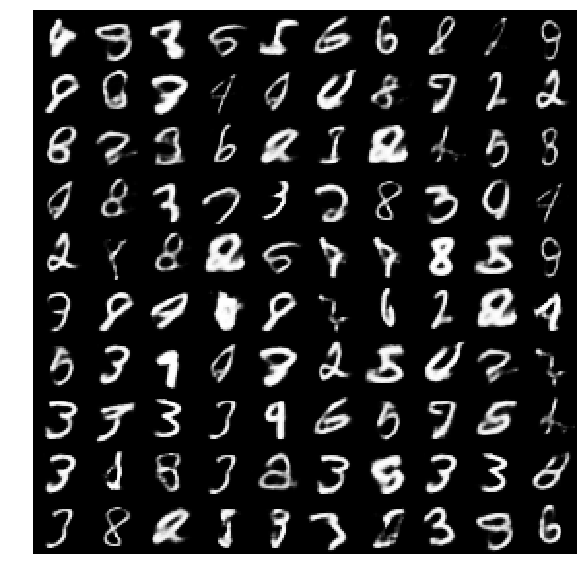

In [18]:
def generation(num_elem):
  model.eval()
  z = torch.randn(num_elem, LATENT_DIM)
  if CUDA:
    z = z.cuda()
  out = model.decode(z).cpu()
  out = out.view(num_elem, 28, 28).data.numpy()
  return out
generated = generation(100)
display_dataset(generated, img_rows, img_cols)

## Latent Space Visualization

Obtain features from the latent space

In [0]:
def get_features(dataset, SAMPLE_SIZE=1000):
  model.eval()
  indices = np.random.randint(0, len(dataset), size=SAMPLE_SIZE)
  random_loader = torch.utils.data.DataLoader(dataset, batch_size=SAMPLE_SIZE, sampler=SubsetRandomSampler(indices))
  it = iter(random_loader)
  data, _labels = it.next()
  if CUDA:
    data = data.cuda()
    
  features = model.encode(data) #vae
  labels = _labels.data.numpy()
  return features.cpu().detach().numpy(), labels

features, labels = get_features(test_dataset, 5000)

## Visualize features with T-SNE

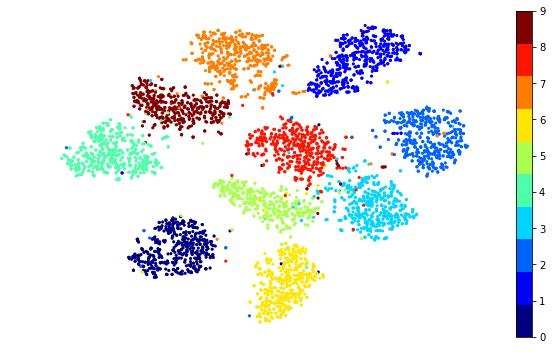

In [20]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

def plot_clusters_tsne(test_features, test_labels, samples=1000, components=2):
  # reduce dimensionality to 2D, we consider a subset of data because TSNE
  # is a slow algorithm
  tsne_features = TSNE(n_components=components).fit_transform(test_features[:samples,])
  fig = plt.figure(figsize=(10, 6))
  plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
              edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
  plt.grid(False)
  plt.axis('off')
  plt.colorbar()
  plt.show()
  
plot_clusters_tsne(features, labels, 5000)